In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
# 导入数据集
from torch.utils.data import DataLoader

from utils.dataset import ERA5SstDataset

data_set = ERA5SstDataset(width=15, step=15, lon=[60, 80], lat=[160, 180])
print(data_set.shape)

train_dataloader = DataLoader(data_set, batch_size=20, shuffle=False)

242.0
(30985, 721, 1440)


In [7]:
loader_itr = iter(train_dataloader)

x_train, y_train = next(loader_itr)
x_test, y_test = next(loader_itr)

from torch import unsqueeze, mean, min, max
from keras import optimizers, utils

from models.model import ssim_loss

# 增加通道维度
x_train = unsqueeze(x_train, dim=-1)
y_train = unsqueeze(y_train, dim=-1)
x_test = unsqueeze(x_test, dim=-1)
y_test = unsqueeze(y_test, dim=-1)

print(mean(x_train), mean(y_train), mean(x_test), mean(y_test))
print(min(x_train), min(y_train), min(x_test), min(y_test))
print(max(x_train), max(y_train), max(x_test), max(y_test))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

from models.LSTM import Conv2DLSTMNetwork

model = Conv2DLSTMNetwork(shape=x_train.shape)

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=ssim_loss)

model.summary()
model.build(input_shape=x_train.shape)
utils.plot_model(model, show_shapes=True)

tensor(26.2916) tensor(26.3499) tensor(26.0274) tensor(26.0595)
tensor(15.2997) tensor(15.2997) tensor(16.4774) tensor(16.5839)
tensor(29.9628) tensor(29.8398) tensor(30.2716) tensor(30.1857)
torch.Size([20, 14, 80, 80, 1]) torch.Size([20, 80, 80, 1]) torch.Size([20, 14, 80, 80, 1]) torch.Size([20, 80, 80, 1])
Conv2DLSTMNetwork init shape: torch.Size([20, 14, 80, 80, 1])


Model: "conv2dlstm_network_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (20, 80, 80, 1)        │     2,875,457 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,875,457 (10.97 MB)

 Trainable params: 2,875,329 (10.97 MB)

 Non-trainable params: 128 (512.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [9]:
# 训练模型
from keras.api.callbacks import ReduceLROnPlateau, EarlyStopping

# 动态调整学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=5, epochs=100, validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stopping])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - loss: 0.0083 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - loss: 0.0078 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - loss: 0.0074 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - loss: 0.0062 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - loss: 0.0064 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - loss: 0.0069 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - loss: 0.0075 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - loss: 0.0067 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - loss: 0.0069 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━

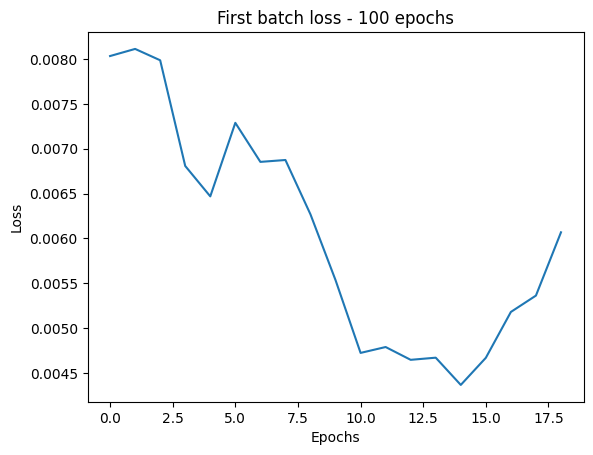

In [11]:
# 损失函数曲线

import matplotlib.pyplot as plt

plt.title("First batch loss - 100 epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label='train')


In [14]:
# 使用下一批数据进行迭代

n = 5
history_all = []
history_t = []

while n > 0:
    print(f"Batch {n}/5 ---------------------------------")
    x_train, y_train = next(loader_itr)
    x_test, y_test = next(loader_itr)

    x_train = unsqueeze(x_train, dim=-1)
    y_train = unsqueeze(y_train, dim=-1)
    x_test = unsqueeze(x_test, dim=-1)
    y_test = unsqueeze(y_test, dim=-1)

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss=ssim_loss)
    history_t = model.fit(x_train, y_train, batch_size=5, epochs=20, validation_data=(x_test, y_test), callbacks=[reduce_lr])
    history_all.append(history_t)

    # 更新模型
    print("Current model loss: ", history_t.history['loss'][-1])
    print("Update model...")
    if history_t.history['loss'][-1] != np.inf \
        and history_t.history['loss'][-1] != -np.inf \
        and history_t.history['loss'][-1] != 1.0:
        model.save('./Conv2DLSTMNetwork.keras')
    else: break

    n -= 1

Batch 5/5 ---------------------------------
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step - loss: 0.1348 - val_loss: 0.0996 - learning_rate: 1.0000e-04
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - loss: 0.0976 - val_loss: 0.0918 - learning_rate: 1.0000e-04
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - loss: 0.0882 - val_loss: 0.0874 - learning_rate: 1.0000e-04
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - loss: 0.0828 - val_loss: 0.0831 - learning_rate: 1.0000e-04
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - loss: 0.0864 - val_loss: 0.0804 - learning_rate: 1.0000e-04
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - loss: 0.0767 - val_loss: 0.0734 - learning_rate: 1.0000e-04
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - loss: 0.0708 - val_loss: 0.0731 - learning_rate: 1.0000e-04
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - loss: 0.0723 - val_loss: 0.0698 - learning_rate: 1.0000e-04
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - loss: 0.0703 - val_loss: 0

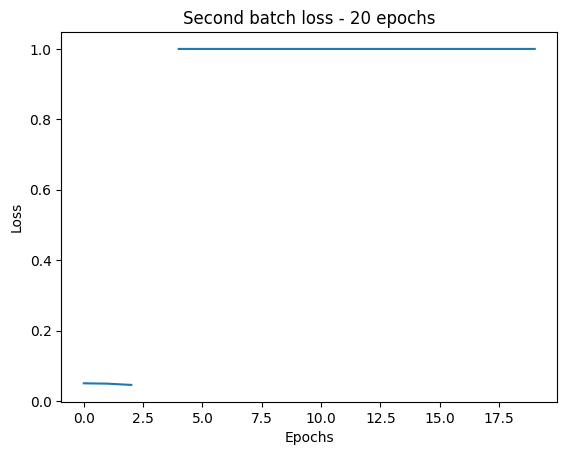

In [18]:
# 损失函数曲线

import matplotlib.pyplot as plt

plt.title("Second batch loss - 20 epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_t.history['loss'], label='train')

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.0034
0.0033921003341674805
(80, 80)
torch.Size([80, 80])
[[16.394281 20.434517 21.346554 ... 20.474285 20.126722 17.212015]
 [22.286438 23.640524 23.815897 ... 22.334478 22.320211 21.057148]
 [23.93823  24.163996 24.273552 ... 22.750574 22.641195 22.464283]
 ...
 [28.194658 29.4499   28.75429  ... 28.303675 28.443825 27.256905]
 [27.483772 30.479279 29.303    ... 28.979628 29.8545   26.756067]
 [22.273758 28.07704  28.102892 ... 28.14087  27.902735 21.89073 ]]
[[23.94815  23.841705 23.747955 ... 22.533112 22.5253   22.540924]
 [24.220612 24.131744 24.03897  ... 22.83194  22.780182 22.783112]
 [24.54483  24.471588 24.392487 ... 23.228424 23.177643 23.109283]
 ...
 [28.811432 28.758698 28.7128   ... 28.314362 28.18155  28.088776]
 [28.845612 28.840729 28.80655  ... 28.466705 28.317291 28.179596]
 [28.864166 28.89151  28.907135 ... 28.583893 28.49112  28.36905 ]]
RMSE:  0.09523158


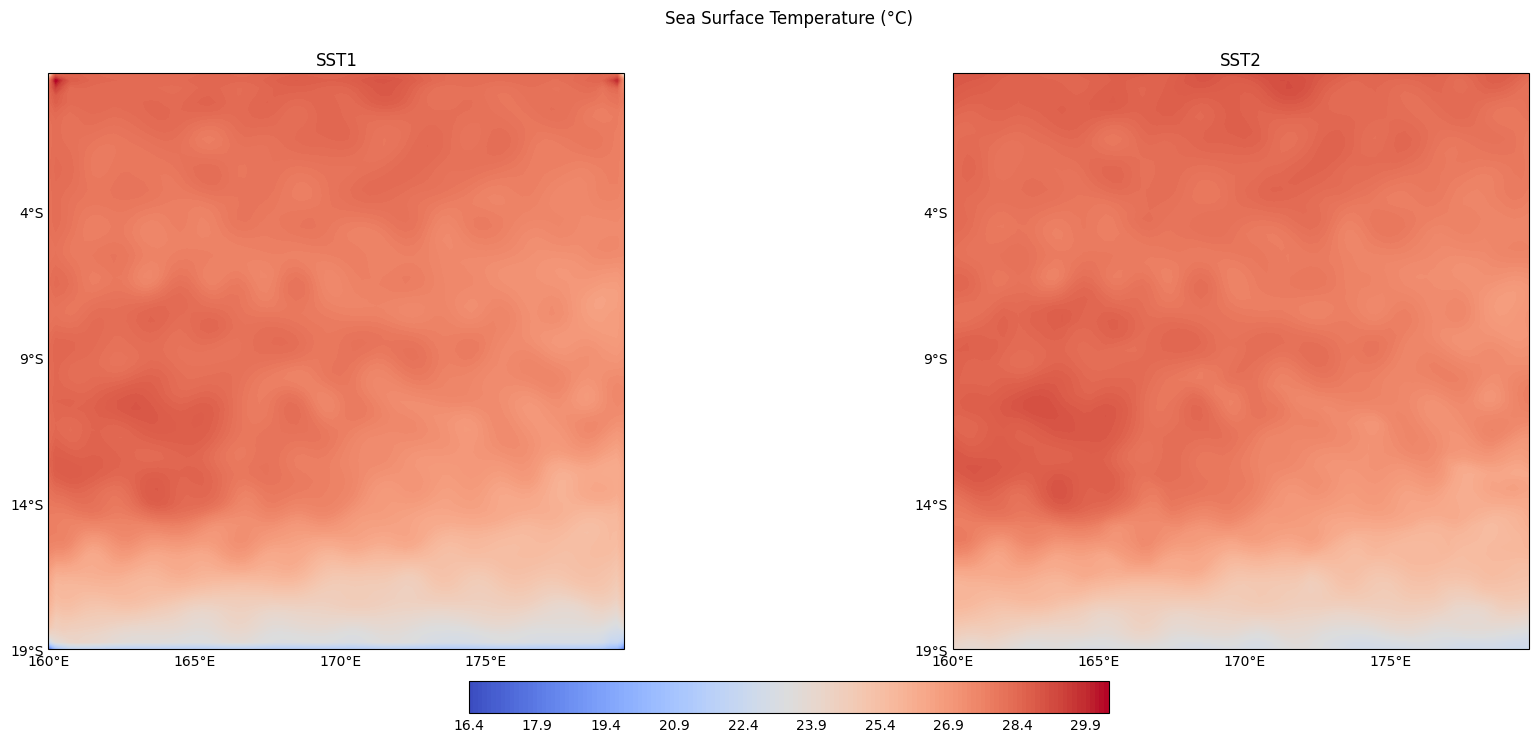

(<Figure size 2000x800 with 3 Axes>,
 (<GeoAxes: title={'center': 'SST1'}>, <GeoAxes: title={'center': 'SST2'}>))

In [29]:
# 预测
from utils.plot import plot_sst_distribution_compare # 导入绘图函数，绘制SST分布的比较图
from models.model import ssim_loss # 导入自定义的SSIM损失函数，模型训练时计算损失

from keras.src.saving import load_model  # 从Keras中导入加载模型的函数

#saved_model = load_model('./Conv2DLSTMNetwork.keras', custom_objects={'ssim_loss': ssim_loss, 'Conv2DLSTMNetwork': Conv2DLSTMNetwork})

y_pred = model.predict(x_test) # 使用模型进行预测

print(model.evaluate(x_test,y_test)) # x_test测试数据

print(y_pred[15, :, :, 0].shape)  # 打印第15个样本的预测结果的形状
print(y_test[15, :, :, 0].shape)

y = y_pred[15, :, :, 0]
g = y_test[15, :, :, 0].numpy()

print(y)
print(g)

# 计算RMSE
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y, g)

print("RMSE: ", rmse)

plot_sst_distribution_compare(y, g)